See [fast_wcs_interp_experimentation](fast_wcs_interp_experimentation.ipynb) for part 1

In [1]:
from pathlib import Path
#import psutil
#import pickle

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.preprocessing import StandardScaler

# Data loading

In [3]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [4]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [5]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths) if 'jw02609010001_03101_00002_nrs2_cal' in p.name}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>}

In [6]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [7]:
slit_all.keys()

dict_keys(['jw02609010001_03101_00002_nrs2_cal.fits'])

In [8]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [9]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-03-13 01:57:40,978 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [10]:
wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

In [11]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

phoenix_lowres = FluxConservingResampler().resample1d(phoenix_sub_spec, 
                            (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

In [12]:
vs = np.linspace(-1000, 1000, 13)
oss = np.linspace(-1, 1, 11)

grid = np.array(np.meshgrid(vs, oss, oss, indexing='ij'))
vgrid, raogrid, decogrid = grid

saxis = np.linspace(phoenix_lowres.spectral_axis[0], phoenix_lowres.spectral_axis[-1], 27)
saxis.shape

zp1g = (vgrid << u.km/u.s)/constants.c + 1
xm0, ym0 = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + (oss << u.arcsec),  
                                                 (slit.source_dec<<u.deg) + (oss << u.arcsec)),
                                                np.multiply.outer(saxis, zp1g))

gridall = np.array(np.meshgrid(saxis.value, vs, oss, oss, indexing='ij'))

gridallflat = gridall.reshape(gridall.shape[0], gridall.size//gridall.shape[0])


# xm0flat = xm0.reshape(xm0.shape[0], xm0.size//xm0.shape[0])
# ym0flat = ym0.reshape(ym0.shape[0], ym0.size//ym0.shape[0])

# notnan = ~np.isnan(xm0.ravel())

# xfit = gridallflat[:, notnan].T
# yfit = xm0.ravel()[notnan]

# xtimetest = xfit[:2000*20]

# xfit.shape, yfit.shape, xfit.size

In [21]:
sspan = saxis[0], saxis[-1]
raospan = decospan = oss[0], oss[-1]

### Cuda/torch preliminaries

In [13]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [15]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 
              

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True


In [16]:
torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

Using cuda device


And set up some of the test data grids from the above

In [17]:
msk0 =  gridallflat[1]==0

X_test = torch.from_numpy(gridallflat.T[msk0][:, [0, 2, 3]].astype('float32')).to(torch_device)
y_test = torch.from_numpy(np.array([xm0.ravel(), ym0.ravel()], dtype=np.float32).T[msk0]).to(torch_device)

x_speed_test = torch.from_numpy(np.repeat(gridallflat.T[msk0][:, [0, 2, 3]],(30*2000)//np.sum(msk0), axis=0).astype('float32')).to(torch_device)

# Set up model prelims

Using the simpler velocity-less model for now

In [18]:
param_simplers = 'lambda,raoff,decoff'.split(',')
lptp = np.ptp(phoenix_lowres.spectral_axis)
lmin = np.min(phoenix_lowres.spectral_axis)
def ptrans_simpler(urand): # 3 x batch size
    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1) << u.arcsec
    do = (urand[2]*2 - 1) << u.arcsec
    return l,ro,do

base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
def make_batch_simpler(rng, batch_size):
    l, ro, do = ptrans_simpler(rng.random(size=(len(param_simplers), batch_size)))
    l0 = l

    sc = base_sc.spherical_offsets_by(ro, do)
    
    outs = slit.meta.wcs.world_to_pixel(sc, l0)
    ins = np.array([l.value, ro.value, do.value])

    return ins, outs

def train_network_simpler(batch_size, n_batches, seed=42, nnmodel=None, loss_fn=None, optimizer=None):
    if nnmodel is None:
        nnmodel = NeuralNetwork(3, 2).to(torch_device)
    
    #msk0 = gridallflat[1]==0
    #X_test = torch.from_numpy(gridallflat.T[msk0][:, [0, 2, 3]].astype('float32')).to(torch_device)
    #y_test = torch.from_numpy(np.array([xm0.ravel(), ym0.ravel()], dtype=np.float32).T[msk0]).to(torch_device)

    if loss_fn is None:
        loss_fn = nn.MSELoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(nnmodel.parameters())
    
    rng = np.random.default_rng(seed)
    
    batchi_test = []
    loss_test = []
    
    nnmodel.train()
    for batchi in tqdm(list(range(n_batches))):
        ins, (xo, yo) = make_batch_simpler(rng, batch_size)
        X = torch.from_numpy(ins.T).to(torch_device, dtype=torch.float32)
        y = torch.from_numpy(np.array([xo, yo], dtype=np.float32).T).to(torch_device)
        
        # Compute prediction error
        pred = nnmodel(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if batchi % 25 == 0 or batchi == (n_batches-1):
            with torch.no_grad():
                nnmodel.eval()
                batchi_test.append(batchi)
                loss_test.append(loss_fn(nnmodel(X_test), y_test).item())
                print('test loss at batch', batchi, 'is', loss_test[-1])
            nnmodel.train()
    
    nnmodel.eval()
    return nnmodel, X_test, y_test, batchi_test, loss_test

First, how do we make polynomials?

In [19]:
import itertools
list(itertools.combinations_with_replacement('xyzw', 3))

[('x', 'x', 'x'),
 ('x', 'x', 'y'),
 ('x', 'x', 'z'),
 ('x', 'x', 'w'),
 ('x', 'y', 'y'),
 ('x', 'y', 'z'),
 ('x', 'y', 'w'),
 ('x', 'z', 'z'),
 ('x', 'z', 'w'),
 ('x', 'w', 'w'),
 ('y', 'y', 'y'),
 ('y', 'y', 'z'),
 ('y', 'y', 'w'),
 ('y', 'z', 'z'),
 ('y', 'z', 'w'),
 ('y', 'w', 'w'),
 ('z', 'z', 'z'),
 ('z', 'z', 'w'),
 ('z', 'w', 'w'),
 ('w', 'w', 'w')]

In [20]:
t=torch.tensor([[1,2,3,4],[5,6,7,8],[9,10,11,12]]).T

t1=torch.tensor([[1,2,3,4]]).T
combs=torch.combinations(torch.tensor([0,1,2,3]), with_replacement=True)
torch.prod(t1[combs], 1)

tensor([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 4],
        [ 6],
        [ 8],
        [ 9],
        [12],
        [16]])

Ok that seems to be doing the right thing.  Try adding to the  NN

# Set up Model and run

In [21]:
# Define model
class NeuralNetworkPoly(nn.Module):
    def __init__(self, in_n, out_n, polydeg):
        
        in_feature_idxs =  torch.from_numpy(np.arange(in_n)).to(torch_device, dtype=torch.int)
        self.combs = torch.combinations(in_feature_idxs, polydeg, with_replacement=True).to(torch_device)
        
        super().__init__()
        self.primary_stack = nn.Sequential(
            # nn.Linear(self.combs.shape[0], 1024),
            # nn.LeakyReLU(),
            # nn.Dropout(0.2),
            
            # nn.Linear(1024, 512),
            # nn.LeakyReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(self.combs.shape[0], 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, out_n),
        )

    @property
    def in_n(self):
        return torch.max(self.combs).item() + 1
        
    @property
    def out_n(self):
        return self.primary_stack[-1].out_features

    @property
    def polydeg(self):
        return self.combs.shape[1]

    def forward(self, x):
        xwpoly = torch.prod(x.T[self.combs], 1).T
        return self.primary_stack(xwpoly)

nnpmodel = NeuralNetworkPoly(3, 2, 3).to(torch_device)
print(nnpmodel)
nnpmodel.in_n, nnpmodel.out_n, nnpmodel.polydeg, X_test.shape, nnpmodel(X_test).shape

NeuralNetworkPoly(
  (primary_stack): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)


(3, 2, 3, torch.Size([3267, 3]), torch.Size([3267, 2]))

In [22]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
nnpmodel(x_speed_test)
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end), 'ms')

7.477248191833496 ms


Not clear why the execution time got so much longer but eh, still pretty fast. Lets try training it

  0%|          | 0/2500 [00:00<?, ?it/s]

test loss at batch 0 is 2.066374513602406e+21
test loss at batch 25 is 5.269214862558364e+18
test loss at batch 50 is 5.4749868144292e+18
test loss at batch 75 is 3.8253054066373427e+18
test loss at batch 100 is 1.7737724275416105e+18
test loss at batch 125 is 6.906495016139489e+17
test loss at batch 150 is 1.4431788304443638e+18
test loss at batch 175 is 5.97925473276448e+18
test loss at batch 200 is 2.045504384328427e+19
test loss at batch 225 is 2.5579867540348207e+19
test loss at batch 250 is 3.80039685031938e+19
test loss at batch 275 is 3.4743067703861314e+19
test loss at batch 300 is 4.263603067110713e+19
test loss at batch 325 is 3.6022362676918223e+19
test loss at batch 350 is 5.398948658445235e+19
test loss at batch 375 is 5.6705742099942736e+19
test loss at batch 400 is 5.715819113477256e+19
test loss at batch 425 is 4.612335609897078e+19
test loss at batch 450 is 4.057241886958551e+19
test loss at batch 475 is 4.847950396417848e+19
test loss at batch 500 is 5.10486844062910

Text(0, 0.5, 'y pixel')

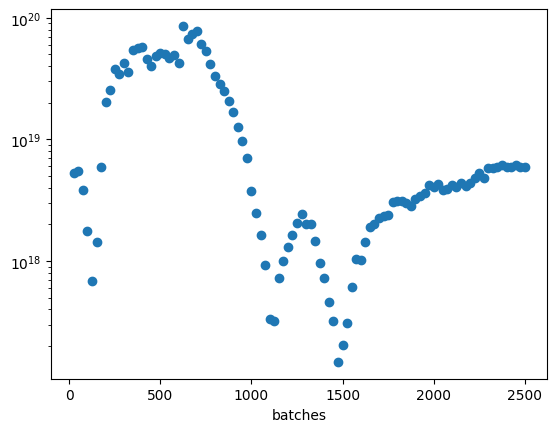

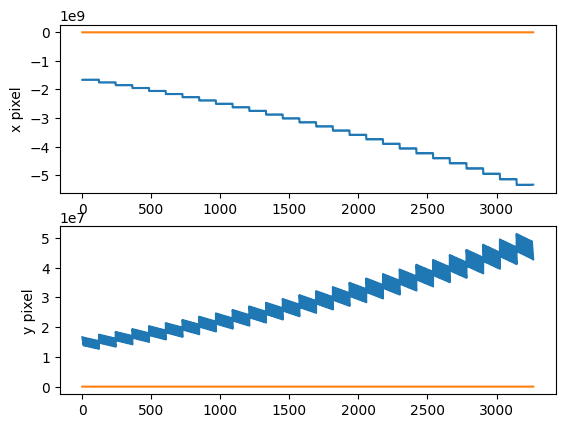

In [32]:
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4, 2500, 42, nnmodel=NeuralNetworkPoly(3, 2, 3).to(torch_device))

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(y_test.cpu().detach().numpy()[:, 0])
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(y_test.cpu().detach().numpy()[:, 1])

ax2.set_ylabel('y pixel')

  0%|          | 0/500 [00:00<?, ?it/s]

test loss at batch 0 is 4.363613395728009e+21
test loss at batch 25 is 1.0578469100749167e+20
test loss at batch 50 is 1.6578099873048429e+19
test loss at batch 75 is 1.1815430017406468e+19
test loss at batch 100 is 1.914784766316092e+19
test loss at batch 125 is 1.2234931086798356e+19
test loss at batch 150 is 1.316237574189718e+19
test loss at batch 175 is 1.1847016787449217e+19
test loss at batch 200 is 9.246524453200855e+18
test loss at batch 225 is 1.0183572242856673e+19
test loss at batch 250 is 8.539737488145514e+18
test loss at batch 275 is 5.776556465649091e+18
test loss at batch 300 is 4.5914893642146775e+18
test loss at batch 325 is 3.3753948692781466e+18
test loss at batch 350 is 2.299113723173798e+18
test loss at batch 375 is 2.1211583159740662e+18
test loss at batch 400 is 2.9115920025020006e+18
test loss at batch 425 is 3.060745152856326e+18
test loss at batch 450 is 4.901664618067263e+18
test loss at batch 475 is 7.594934293223178e+18
test loss at batch 499 is 8.7837554

Text(0, 0.5, 'y pixel')

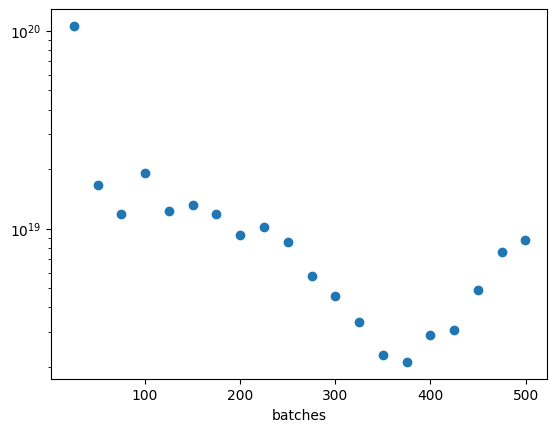

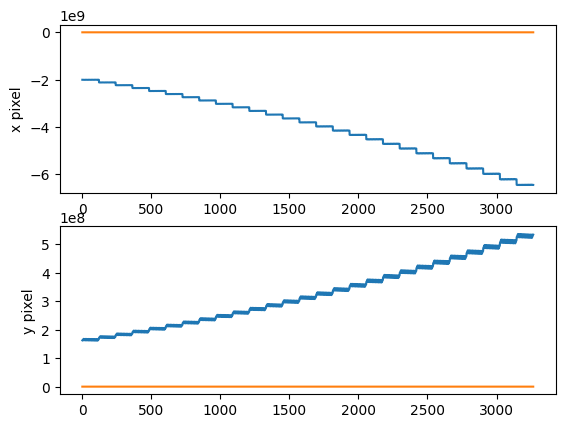

In [47]:
mod = NeuralNetworkPoly(3, 2, 3).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4, 500, 42, nnmodel=mod,
                                                                       optimizer=torch.optim.Adamax(mod.parameters(), lr=1e-4))

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(y_test.cpu().detach().numpy()[:, 0])
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(y_test.cpu().detach().numpy()[:, 1])

ax2.set_ylabel('y pixel')

  0%|          | 0/500 [00:00<?, ?it/s]

test loss at batch 0 is 4.970612434436947e+27
test loss at batch 25 is 1.2265069448183604e+22
test loss at batch 50 is 3.115871246831657e+22
test loss at batch 75 is 2.829555576061522e+22
test loss at batch 100 is 2.413815909559976e+22
test loss at batch 125 is 2.0534349400380312e+22
test loss at batch 150 is 1.7426746312104545e+22
test loss at batch 175 is 1.4729275908794247e+22
test loss at batch 200 is 1.238926859280732e+22
test loss at batch 225 is 1.0372095060709007e+22
test loss at batch 250 is 8.639285001532354e+21
test loss at batch 275 is 7.159406667578036e+21
test loss at batch 300 is 5.902847202446233e+21
test loss at batch 325 is 4.839688630862367e+21
test loss at batch 350 is 3.9457592892014125e+21
test loss at batch 375 is 3.19882321725318e+21
test loss at batch 400 is 2.5807987439887544e+21
test loss at batch 425 is 2.0712806224464729e+21
test loss at batch 450 is 1.654698079127167e+21
test loss at batch 475 is 1.3142124364990754e+21
test loss at batch 499 is 1.048658177

Text(0, 0.5, 'y pixel')

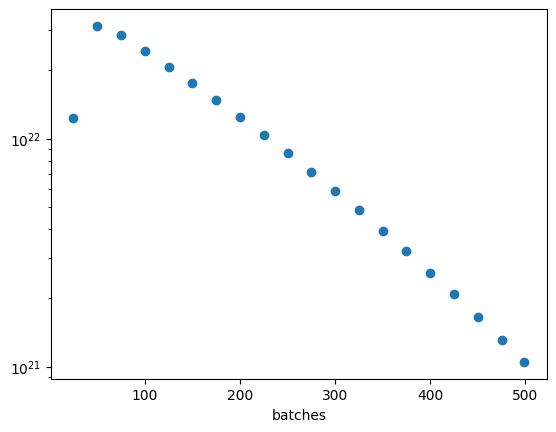

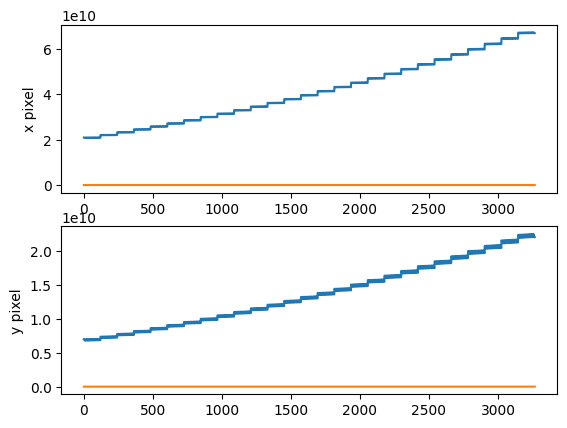

In [48]:
mod = NeuralNetworkPoly(3, 2, 3).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4, 500, 42, nnmodel=mod,
                                                                       optimizer=torch.optim.Adamax(mod.parameters(), lr=1e-1))

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(y_test.cpu().detach().numpy()[:, 0])
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(y_test.cpu().detach().numpy()[:, 1])

ax2.set_ylabel('y pixel')

In [22]:
# Define model
class NeuralNetworkPolyScale(nn.Module):
    def __init__(self, in_n, out_n, polydeg):
        
        in_feature_idxs =  torch.from_numpy(np.arange(in_n)).to(torch_device, dtype=torch.int)
        self.combs = torch.combinations(in_feature_idxs, polydeg, with_replacement=True).to(torch_device)
        
        super().__init__()
        self.primary_stack = nn.Sequential(
            
            nn.Linear(self.combs.shape[0], 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, out_n),
        )

    @property
    def in_n(self):
        return torch.max(self.combs).item() + 1
        
    @property
    def out_n(self):
        return self.primary_stack[-2].out_features

    @property
    def polydeg(self):
        return self.combs.shape[1]

    def forward(self, x):
        scale = torch.tensor([sspan[1].value-sspan[0].value,
                 raospan[1] - raospan[0],
                 decospan[1] - decospan[0]]).to(torch_device, dtype=torch.float32)
        off = torch.tensor([sspan[0].value,
                 raospan[0],
                 decospan[0]]).to(torch_device, dtype=torch.float32)
        xt = ((x- off)/scale).T
        
        xwpoly = torch.prod(xt[self.combs], 1).T
        return self.primary_stack(xwpoly)

nnpsmodel = NeuralNetworkPolyScale(3, 2, 3).to(torch_device)
print(nnpsmodel)
X_test.shape, nnpsmodel(X_test).shape

NeuralNetworkPolyScale(
  (primary_stack): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)


(torch.Size([3267, 3]), torch.Size([3267, 2]))

  0%|          | 0/1500 [00:00<?, ?it/s]

test loss at batch 0 is 706453.5
test loss at batch 25 is 692484.4375
test loss at batch 50 is 633304.3125
test loss at batch 75 is 475942.09375
test loss at batch 100 is 248888.1875
test loss at batch 125 is 142431.359375
test loss at batch 150 is 123877.0625
test loss at batch 175 is 102606.7578125
test loss at batch 200 is 85792.21875
test loss at batch 225 is 71264.625
test loss at batch 250 is 58976.25
test loss at batch 275 is 49158.85546875
test loss at batch 300 is 41660.640625
test loss at batch 325 is 36234.8359375
test loss at batch 350 is 32528.048828125
test loss at batch 375 is 30163.677734375
test loss at batch 400 is 28787.8671875
test loss at batch 425 is 27932.21484375
test loss at batch 450 is 27238.875
test loss at batch 475 is 26447.642578125
test loss at batch 500 is 25550.20703125
test loss at batch 525 is 24556.787109375
test loss at batch 550 is 23439.158203125
test loss at batch 575 is 21999.45703125
test loss at batch 600 is 20385.841796875
test loss at batch

Text(0, 0.5, 'y pixel')

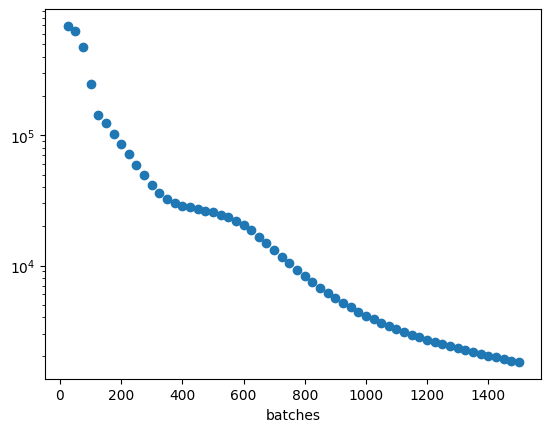

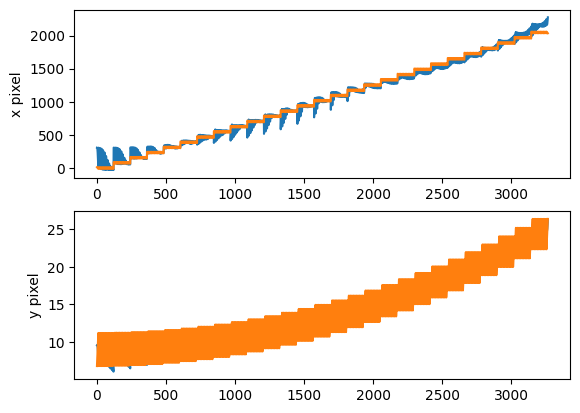

In [22]:
mod = NeuralNetworkPolyScale(3, 2, 3).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4, 1500, 42, nnmodel=mod)

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(y_test.cpu().detach().numpy()[:, 0])
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(y_test.cpu().detach().numpy()[:, 1])

ax2.set_ylabel('y pixel')

  0%|          | 0/500 [00:00<?, ?it/s]

test loss at batch 0 is 706298.4375
test loss at batch 25 is 688351.625
test loss at batch 50 is 612834.6875
test loss at batch 75 is 424329.21875
test loss at batch 100 is 198348.40625
test loss at batch 125 is 138477.75
test loss at batch 150 is 115613.21875
test loss at batch 175 is 95444.78125
test loss at batch 200 is 78902.046875
test loss at batch 225 is 64709.26953125
test loss at batch 250 is 53226.86328125
test loss at batch 275 is 44370.0859375
test loss at batch 300 is 37874.96875
test loss at batch 325 is 33305.546875
test loss at batch 350 is 30413.880859375
test loss at batch 375 is 28775.009765625
test loss at batch 400 is 27488.5703125
test loss at batch 425 is 26188.6171875
test loss at batch 450 is 24715.783203125
test loss at batch 475 is 23011.40625
test loss at batch 499 is 21241.61328125


Text(0, 0.5, 'y pixel')

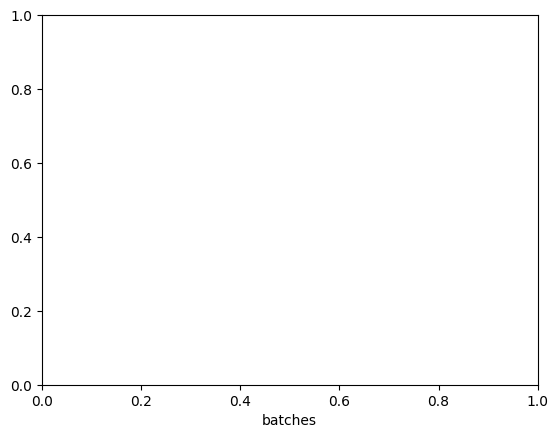

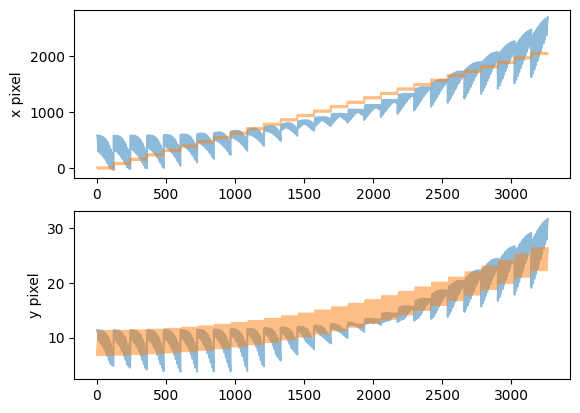

In [29]:
mod = NeuralNetworkPolyScale(3, 2, 3).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4*4*4, 500, 42, nnmodel=mod)

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()
plt.xlabel('batches')

pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

In [26]:
# Define model
class NeuralNetworkScale(nn.Module):
    def __init__(self, in_n, out_n):
        
        super().__init__()
        self.primary_stack = nn.Sequential(
            nn.Linear(in_n, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, out_n),
        )

    @property
    def in_n(self):
        return torch.max(self.combs).item() + 1
        
    @property
    def out_n(self):
        return self.primary_stack[-1].out_features
    def forward(self, x):
        scale = torch.tensor([sspan[1].value-sspan[0].value,
                 raospan[1] - raospan[0],
                 decospan[1] - decospan[0]]).to(torch_device, dtype=torch.float32)
        off = torch.tensor([sspan[0].value,
                 raospan[0],
                 decospan[0]]).to(torch_device, dtype=torch.float32)
        
        xt = ((x- off)/scale)
        
        return self.primary_stack(xt)

nnsmodel = NeuralNetworkScale(3, 2).to(torch_device)
print(nnsmodel)
X_test.shape, nnsmodel(X_test).shape

NeuralNetworkScale(
  (primary_stack): Sequential(
    (0): Linear(in_features=3, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)


(torch.Size([3267, 3]), torch.Size([3267, 2]))

Text(0, 0.5, 'y pixel')

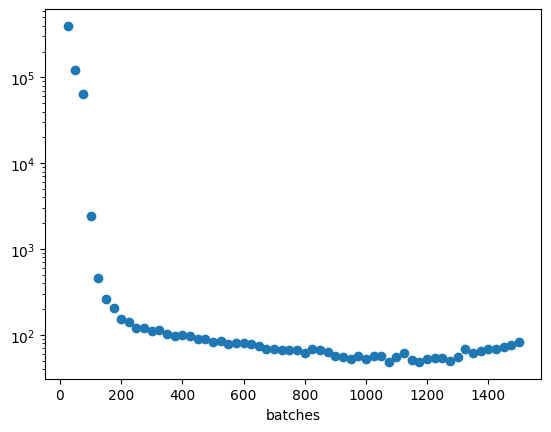

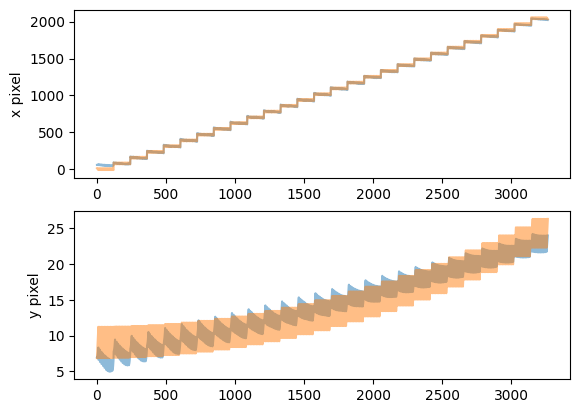

In [26]:
mod = NeuralNetworkScale(3, 2).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4, 1500, 42, nnmodel=mod)

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()
plt.xlabel('batches')

pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

  0%|          | 0/500 [00:00<?, ?it/s]

test loss at batch 0 is 705961.5
test loss at batch 25 is 357066.71875
test loss at batch 50 is 109200.6328125
test loss at batch 75 is 51474.04296875
test loss at batch 100 is 1084.4176025390625
test loss at batch 125 is 449.66168212890625
test loss at batch 150 is 234.78451538085938
test loss at batch 175 is 195.9149169921875
test loss at batch 200 is 155.30902099609375
test loss at batch 225 is 133.8360137939453
test loss at batch 250 is 124.30549621582031
test loss at batch 275 is 116.86349487304688
test loss at batch 300 is 111.12928771972656
test loss at batch 325 is 104.36153411865234
test loss at batch 350 is 100.61228942871094
test loss at batch 375 is 95.90802001953125
test loss at batch 400 is 91.2936782836914
test loss at batch 425 is 88.07022094726562
test loss at batch 450 is 85.63694763183594
test loss at batch 475 is 83.03372955322266
test loss at batch 499 is 80.51026153564453


Text(0, 0.5, 'y pixel')

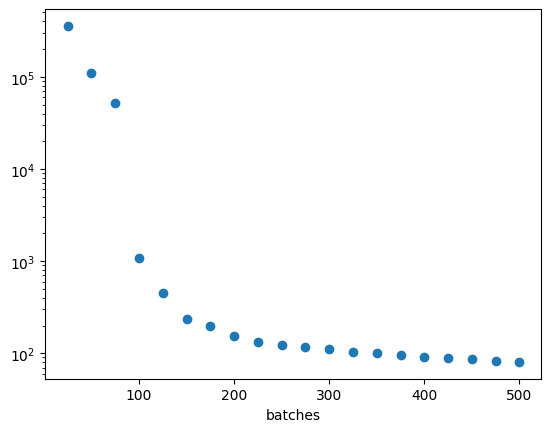

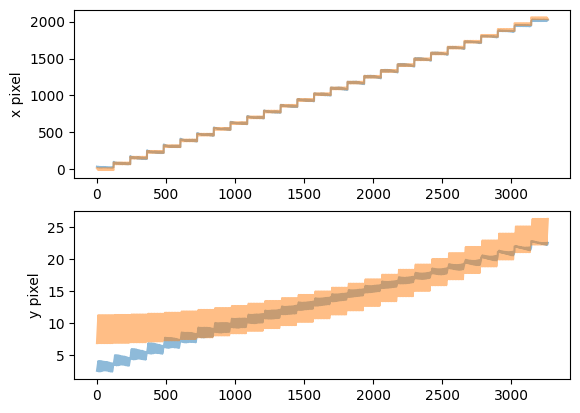

In [28]:
mod = NeuralNetworkScale(3, 2).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4*4*4, 500, 42, nnmodel=mod)

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

In [23]:
# Define model
class NeuralNetworkSillyPolyScale(nn.Module):
    def __init__(self, in_n, out_n, polydeg):
        
        in_feature_idxs =  torch.from_numpy(np.arange(in_n)).to(torch_device, dtype=torch.int)
        self.combs = torch.combinations(in_feature_idxs, polydeg, with_replacement=True).to(torch_device)
        print(self.combs)
        
        super().__init__()
        self.primary_stack = nn.Sequential(
            
            nn.Linear(self.combs.shape[0], out_n),
            #nn.LeakyReLU(),
            #nn.Dropout(0.2),
            nn.Sigmoid()
        )

    @property
    def in_n(self):
        return torch.max(self.combs).item() + 1
        
    @property
    def out_n(self):
        return self.primary_stack[-2].out_features

    @property
    def polydeg(self):
        return self.combs.shape[1]

    def get_polys(self, x):
        
        scale = torch.tensor([sspan[1].value-sspan[0].value,
                 raospan[1] - raospan[0],
                 decospan[1] - decospan[0]]).to(torch_device, dtype=torch.float32)
        off = torch.tensor([sspan[0].value,
                 raospan[0],
                 decospan[0]]).to(torch_device, dtype=torch.float32)
        xt = ((x- off)/scale).T
        return  torch.prod(xt[self.combs], 1).T

    def forward(self, x):
        xwpoly = self.get_polys(x)
        
        out = self.primary_stack(xwpoly)
        
        scale = torch.tensor([2500, 50]).to(torch_device, dtype=torch.float32)
        off = torch.tensor([-100, -50]).to(torch_device, dtype=torch.float32)
        return out*scale + off

nnspsmodel = NeuralNetworkSillyPolyScale(3, 2, 4).to(torch_device)
print(nnspsmodel)
X_test.shape, nnspsmodel(X_test).shape

tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 2],
        [0, 0, 1, 1],
        [0, 0, 1, 2],
        [0, 0, 2, 2],
        [0, 1, 1, 1],
        [0, 1, 1, 2],
        [0, 1, 2, 2],
        [0, 2, 2, 2],
        [1, 1, 1, 1],
        [1, 1, 1, 2],
        [1, 1, 2, 2],
        [1, 2, 2, 2],
        [2, 2, 2, 2]], device='cuda:0', dtype=torch.int32)
NeuralNetworkSillyPolyScale(
  (primary_stack): Sequential(
    (0): Linear(in_features=15, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


(torch.Size([3267, 3]), torch.Size([3267, 2]))

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 1, 1],
        [0, 1, 2],
        [0, 2, 2],
        [1, 1, 1],
        [1, 1, 2],
        [1, 2, 2],
        [2, 2, 2]], device='cuda:0', dtype=torch.int32)


  0%|          | 0/500 [00:00<?, ?it/s]

test loss at batch 0 is 169089.375
test loss at batch 25 is 24440.0703125
test loss at batch 50 is 23252.275390625
test loss at batch 75 is 22414.48828125
test loss at batch 100 is 21780.310546875
test loss at batch 125 is 21288.80859375
test loss at batch 150 is 20870.185546875
test loss at batch 175 is 20516.033203125
test loss at batch 200 is 20210.921875
test loss at batch 225 is 19945.69140625
test loss at batch 250 is 19704.171875
test loss at batch 275 is 19483.28515625
test loss at batch 300 is 19277.115234375
test loss at batch 325 is 19085.41796875
test loss at batch 350 is 18903.138671875
test loss at batch 375 is 18729.572265625
test loss at batch 400 is 18560.900390625
test loss at batch 425 is 18400.306640625
test loss at batch 450 is 18242.34765625
test loss at batch 475 is 18087.98828125
test loss at batch 499 is 17947.685546875


Text(0, 0.5, 'y pixel')

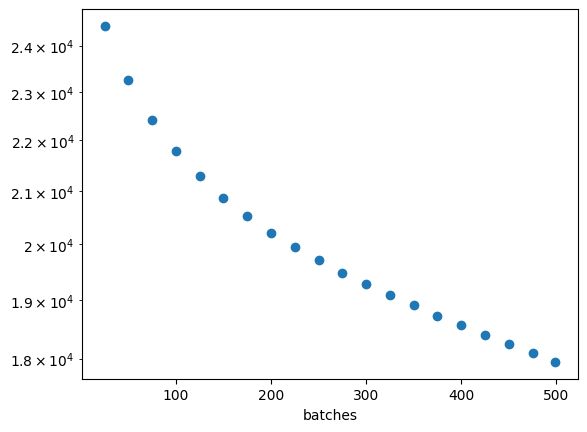

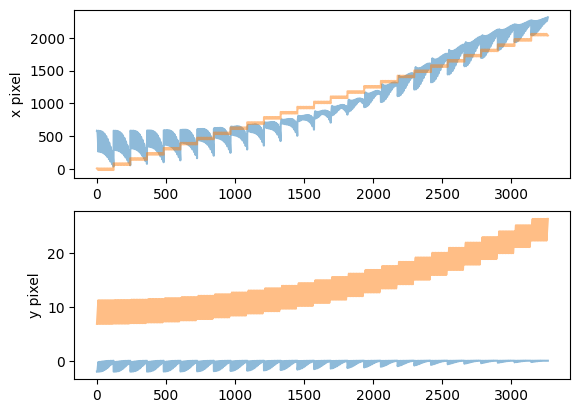

In [24]:
mod = NeuralNetworkSillyPolyScale(3, 2, 3).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4*4, 500, 42, nnmodel=mod,
                                                                       optimizer=torch.optim.Adamax(mod.parameters(), lr=.1))

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

In [26]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(3)

In [27]:
pf.fit(X_test.cpu().numpy())

PolynomialFeatures(degree=3)

In [28]:
pf.get_feature_names_out(), len(pf.get_feature_names_out())

(array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
        'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2',
        'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3'], dtype=object),
 20)

Oooooh, it's *only* the biggest polys, not the earlier orders! Fix

From John

* Add Batch normalization layers
* Check if I'm recycling rng seed

In [ ]:
rng = np.random.def

In [35]:
X_test.shape

torch.Size([3267, 3])

In [34]:
in_n = 3
polydeg = 3


in_feature_idxs = torch.from_numpy(np.arange(in_n)).to(torch_device, dtype=torch.int)
comb1 = torch.combinations(in_feature_idxs, 1, with_replacement=True).to(torch_device)
comb2 = torch.combinations(in_feature_idxs, 2, with_replacement=True).to(torch_device)
comb3 = torch.combinations(in_feature_idxs, 3, with_replacement=True).to(torch_device)
comb1, comb2, comb3

(tensor([[0],
         [1],
         [2]], device='cuda:0', dtype=torch.int32),
 tensor([[0, 0],
         [0, 1],
         [0, 2],
         [1, 1],
         [1, 2],
         [2, 2]], device='cuda:0', dtype=torch.int32),
 tensor([[0, 0, 0],
         [0, 0, 1],
         [0, 0, 2],
         [0, 1, 1],
         [0, 1, 2],
         [0, 2, 2],
         [1, 1, 1],
         [1, 1, 2],
         [1, 2, 2],
         [2, 2, 2]], device='cuda:0', dtype=torch.int32))

Note this is the *same* order as the polynomials in PolynomialFeatures (aside from from the 0th) so weights can be done directly if need be.

In [47]:
p0 = torch.ones(1, X_test.shape[0], device=torch_device)
p1 = torch.prod(X_test.T[comb1], 1)
p2 = torch.prod(X_test.T[comb2], 1)
p3 = torch.prod(X_test.T[comb3], 1)
p0.shape,p1.shape,p2.shape,p3.shape

(torch.Size([1, 3267]),
 torch.Size([3, 3267]),
 torch.Size([6, 3267]),
 torch.Size([10, 3267]))

In [48]:
torch.cat([p0, p1, p2, p3], 0).shape

torch.Size([20, 3267])

In this approach feature 0 is a constant so the bias should be dropped on any linear layer immediately after.

In [87]:
# Define model
class NeuralNetworkSillyPolyScale(nn.Module):
    def __init__(self, in_n, out_n, polydeg, rescale_in=True, rescale_out=True):
        super().__init__()
        
        self.rescale_in = rescale_in
        self.rescale_out = rescale_out

        self.combs = self.set_up_combs(in_n, polydeg)
        n_polys = sum([c.shape[0] for c in self.combs]) + 1
        
        self.primary_stack = nn.Sequential(
            nn.Linear(n_polys, out_n, bias=False),  # the bias is in the feature list instead
            #nn.Sigmoid()
        )

    @property
    def in_n(self):
        return self.combs[0].shape[0]
        
    @property
    def out_n(self):
        return self.primary_stack[-1].out_features

    @property
    def polydeg(self):
        return self.combs.shape[1]

    def rescale_x(self, x):
        
        scale = torch.tensor([sspan[1].value-sspan[0].value,
                 raospan[1] - raospan[0],
                 decospan[1] - decospan[0]]).to(torch_device, dtype=torch.float32)
        off = torch.tensor([sspan[0].value,
                 raospan[0],
                 decospan[0]]).to(torch_device, dtype=torch.float32)
        return ((x- off)/scale)

    def set_up_combs(self, in_n, polydeg):      
        in_feature_idxs = torch.from_numpy(np.arange(in_n)).to(torch_device, dtype=torch.int)
        combs = [torch.combinations(in_feature_idxs, i+1, with_replacement=True).to(torch_device) for i in range(polydeg)]
        return combs

    def get_polys(self, x):
        ps = [torch.prod(x.T[comb], 1) for comb in self.combs]
        ps.insert(0, torch.ones(1, x.shape[0], device=torch_device))
        return torch.cat(ps, 0)

    def forward(self, x):
        if self.rescale_in:
            x = self.rescale_x(x)
        xwpoly = self.get_polys(x)
        
        out = self.primary_stack(xwpoly.T)
        if self.rescale_out:
            scale = torch.tensor([2500, 50]).to(torch_device, dtype=torch.float32)
            off = torch.tensor([-100, -50]).to(torch_device, dtype=torch.float32)
            return out*scale + off
        else:
            return out

nnspsmodel = NeuralNetworkSillyPolyScale(3, 2, 3).to(torch_device)
print(nnspsmodel)
X_test.shape, nnspsmodel(X_test).shape

NeuralNetworkSillyPolyScale(
  (primary_stack): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=False)
  )
)


(torch.Size([3267, 3]), torch.Size([3267, 2]))

  0%|          | 0/500 [00:00<?, ?it/s]

test loss at batch 0 is 705833.625
test loss at batch 25 is 687336.0
test loss at batch 50 is 669244.9375
test loss at batch 75 is 651449.1875
test loss at batch 100 is 633961.8125
test loss at batch 125 is 616760.875
test loss at batch 150 is 599873.125
test loss at batch 175 is 583320.0
test loss at batch 200 is 567062.75
test loss at batch 225 is 551128.5625
test loss at batch 250 is 535506.0625
test loss at batch 275 is 520200.9375
test loss at batch 300 is 505227.40625
test loss at batch 325 is 490556.34375
test loss at batch 350 is 476177.40625
test loss at batch 375 is 462119.96875
test loss at batch 400 is 448369.03125
test loss at batch 425 is 434951.78125
test loss at batch 450 is 421850.65625
test loss at batch 475 is 409089.1875
test loss at batch 499 is 397137.03125


Text(0, 0.5, 'y pixel')

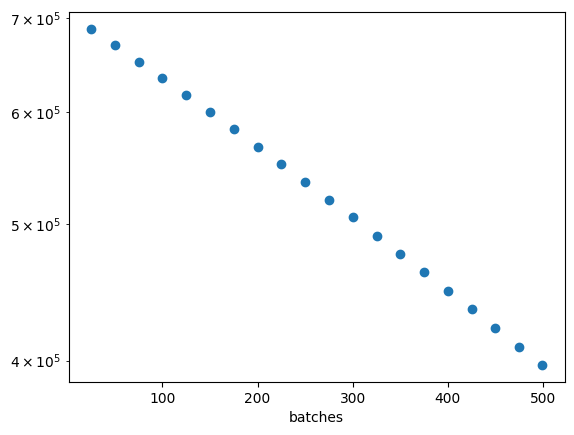

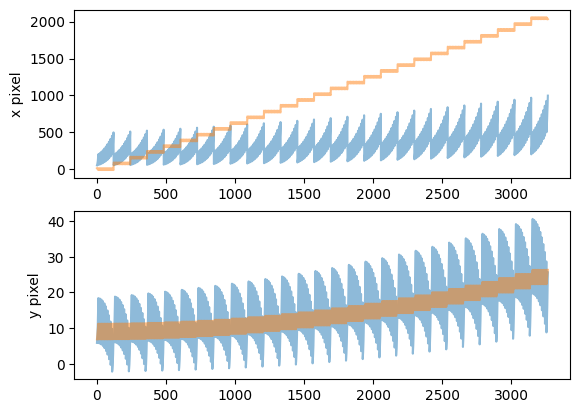

In [70]:
mod = NeuralNetworkSillyPolyScale(3, 2, 3).to(torch_device)
nnmodel, X_test, y_test, batchi_test, loss_test = train_network_simpler(1024*4*4*4, 500, 42, nnmodel=mod,
                                                                       optimizer=torch.optim.Adamax(mod.parameters(), lr=.1))

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

Try training with random batches of the test dataset instead

  0%|          | 0/60000 [00:00<?, ?it/s]

test loss at batch 0 is 706747.5
test loss at batch 1000 is 648800.875
test loss at batch 2000 is 594232.625
test loss at batch 3000 is 544178.125
test loss at batch 4000 is 496351.15625
test loss at batch 5000 is 452752.8125
test loss at batch 6000 is 411661.25
test loss at batch 7000 is 374160.96875
test loss at batch 8000 is 339577.21875
test loss at batch 9000 is 307266.09375
test loss at batch 10000 is 278145.0625
test loss at batch 11000 is 251855.359375
test loss at batch 12000 is 228383.65625
test loss at batch 13000 is 207685.34375
test loss at batch 14000 is 189725.625
test loss at batch 15000 is 174361.296875
test loss at batch 16000 is 161797.359375
test loss at batch 17000 is 151644.734375
test loss at batch 18000 is 143787.953125
test loss at batch 19000 is 138035.3125
test loss at batch 20000 is 134175.328125
test loss at batch 21000 is 131387.765625
test loss at batch 22000 is 129023.59375
test loss at batch 23000 is 126552.4453125
test loss at batch 24000 is 124094.117

Text(0, 0.5, 'y pixel')

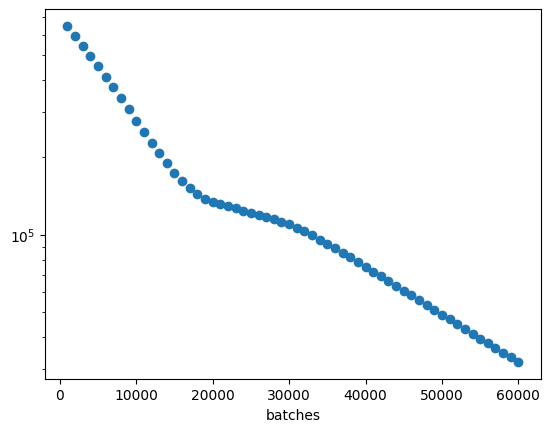

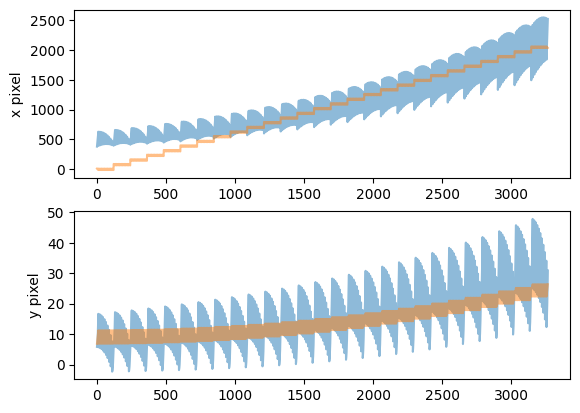

In [38]:
nnmodel = NeuralNetworkSillyPolyScale(3, 2, 3).to(torch_device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nnmodel.parameters(), lr=.01)

Xs, ys = make_batch_simpler(np.random.default_rng(45), 2**18)
Xs = torch.from_numpy(Xs.T).to(torch_device, dtype=torch.float32)
ys = torch.from_numpy(np.array(ys, dtype='float32').T).to(torch_device)

n_batches = 60000
batch_size = Xs.shape[1]//2

batchi_test = []
loss_test = []
nnmodel.train()
for batchi in tqdm(list(range(n_batches))):
    idxs = torch.randperm(Xs.shape[1])[:batch_size]
    X = Xs[idxs]
    y = ys[idxs]
    
    # Compute prediction error
    pred = nnmodel(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batchi % 1000 == 0 or batchi == (n_batches-1):
        with torch.no_grad():
            nnmodel.eval()
            batchi_test.append(batchi)
            loss_test.append(loss_fn(nnmodel(X_test), y_test).item())
            print('test loss at batch', batchi, 'is', loss_test[-1])
        nnmodel.train()

nnmodel.eval()

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()
plt.xlabel('batches')

pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.30266e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


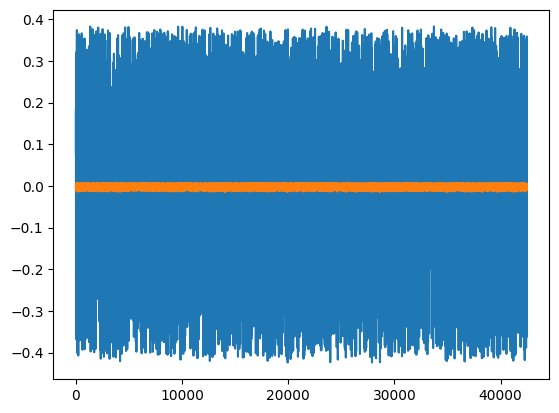

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

xfit = Xs[:42471].cpu().numpy()
yfit = ys[:42471].cpu().numpy()

modelx = make_pipeline(PolynomialFeatures(3), Ridge(alpha=1e-3))
modelx.fit(xfit, yfit)

plt.plot(modelx.predict(xfit) - yfit)

Text(0, 0.5, 'y pixel')

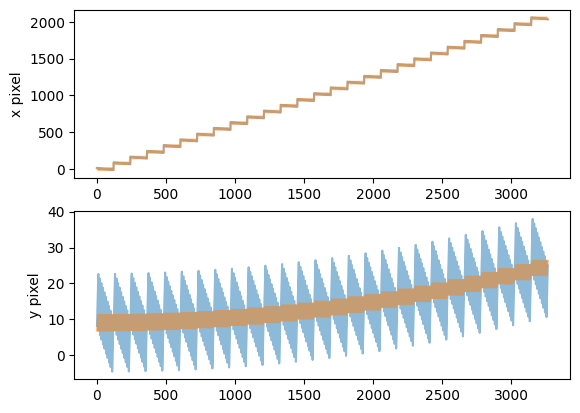

In [101]:
nnmodel = NeuralNetworkSillyPolyScale(3, 2, 3, rescale_in=False, rescale_out=False).to(torch_device)

coefs = modelx.steps[1][-1].coef_.copy()
coefs[:, 0] = modelx.steps[1][-1].intercept_
nnmodel.primary_stack[0].weight = nn.Parameter(torch.from_numpy(coefs).to(torch_device, dtype=torch.float32))


pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

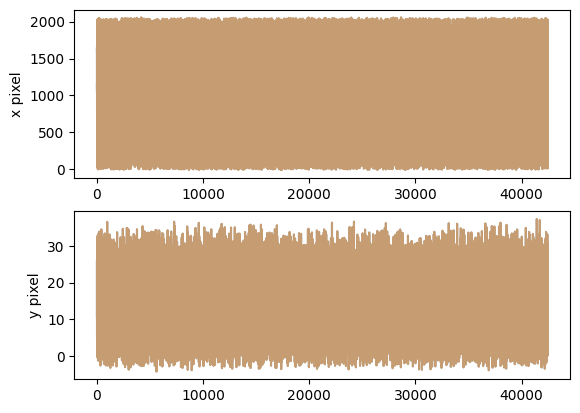

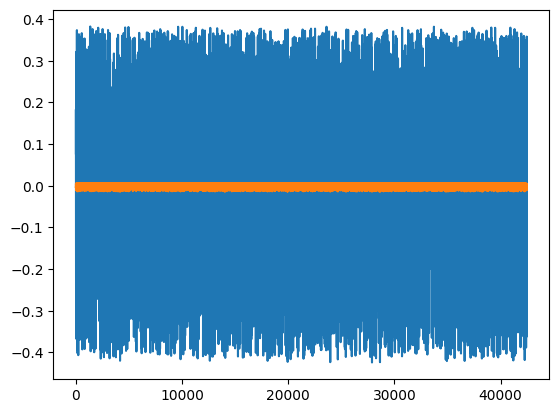

In [114]:
ynfit = nnmodel(torch.from_numpy(xfit).to(torch_device)).cpu().detach().numpy()

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ynfit[:, 0], alpha=.5)
ax1.plot(yfit[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(ynfit[:, 1], alpha=.5)
ax2.plot(yfit[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

plt.figure()
plt.plot(ynfit[:, 0]- yfit[:, 0])
plt.plot(ynfit[:, 1]- yfit[:, 1])

tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

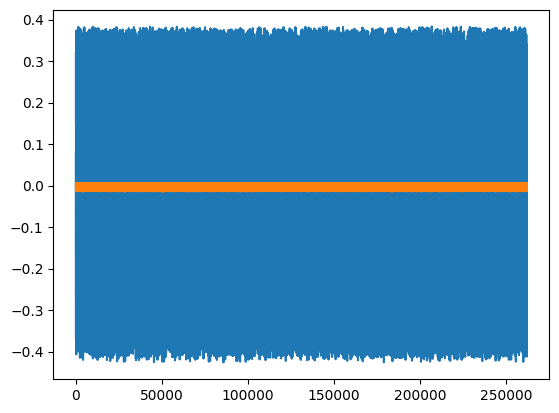

In [121]:
Xs, ys = make_batch_simpler(np.random.default_rng(45), 2**18)
Xs = torch.from_numpy(Xs.T).to(torch_device, dtype=torch.float32)
ys = torch.from_numpy(np.array(ys, dtype='float32').T).to(torch_device)

ypred = nnmodel(Xs).cpu().detach().numpy()

plt.figure()
plt.plot(ypred[:, 0]- ys.cpu().detach().numpy()[:, 0])
plt.plot(ypred[:, 1]- ys.cpu().detach().numpy()[:, 1])

loss_fn = nn.MSELoss()
pred = nnmodel(Xs)
loss_fn(pred, ys)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)
test loss at batch 0 is 4.704283039427985e+18
tensor(6.9764e+18, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.9744e+18, device='cuda:0', grad_fn=<MseLossBackward0>)
test loss at batch 2 is 4.70315109220719e+18


Text(0, 0.5, 'y pixel')

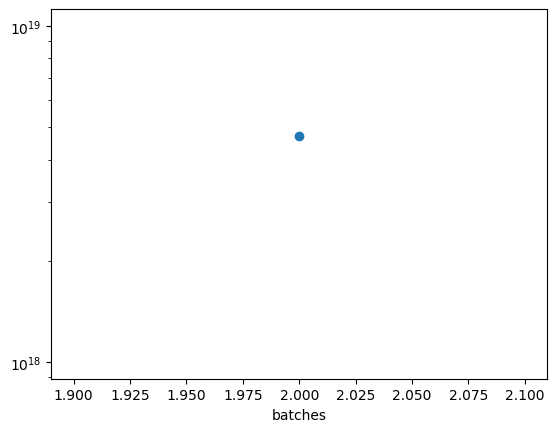

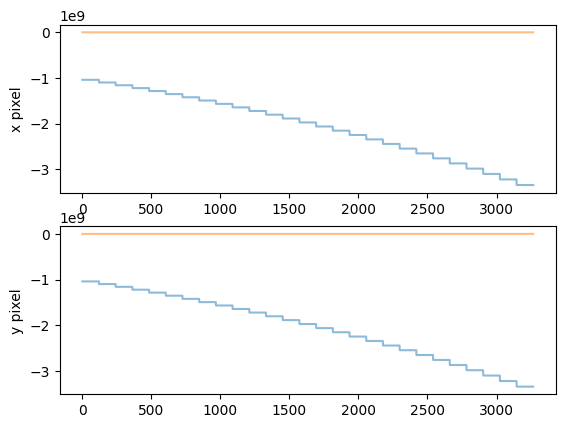

In [125]:
nnmodel = NeuralNetworkSillyPolyScale(3, 2, 3, rescale_in=False, rescale_out=False).to(torch_device)

# initialize with ridge-regression results
coefs = modelx.steps[1][-1].coef_.copy()
coefs[:, 0] = modelx.steps[1][-1].intercept_
nnmodel.primary_stack[0].weight = nn.Parameter(torch.from_numpy(coefs).to(torch_device, dtype=torch.float32))

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nnmodel.parameters())

Xs, ys = make_batch_simpler(np.random.default_rng(45), 2**18)
Xs = torch.from_numpy(Xs.T).to(torch_device, dtype=torch.float32)
ys = torch.from_numpy(np.array(ys, dtype='float32').T).to(torch_device)

n_batches = 3
batch_size = Xs.shape[1]//2

batchi_test = []
loss_test = []
nnmodel.train()
for batchi in tqdm(list(range(n_batches))):
    idxs = torch.randperm(Xs.shape[1])[:batch_size]
    X = Xs[idxs]
    y = ys[idxs]
    
    # Compute prediction error
    pred = nnmodel(X)
    loss = loss_fn(pred, y)
    print(loss)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batchi % 1000 == 0 or batchi == (n_batches-1):
        with torch.no_grad():
            nnmodel.eval()
            batchi_test.append(batchi)
            loss_test.append(loss_fn(nnmodel(X_test), y_test).item())
            print('test loss at batch', batchi, 'is', loss_test[-1])
        nnmodel.train()

nnmodel.eval()

plt.scatter(batchi_test[1:], loss_test[1:])
plt.semilogy()
plt.xlabel('batches')

pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0], alpha=.5)
ax1.plot(y_test.cpu().detach().numpy()[:, 0], alpha=.5)
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1], alpha=.5)
ax2.plot(y_test.cpu().detach().numpy()[:, 1], alpha=.5)

ax2.set_ylabel('y pixel')

This seems like utter nonesense...